# Notebook for analysing the univariate stats of all tables

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-dark')
 
from sqlalchemy import create_engine,text
user = 'root'
passwords = '7003890541'
host = 'localhost'
port = 3306
database = 'synthea'

engine = create_engine(f"mysql+pymysql://{user}:{passwords}@{host}:{port}/{database}")
def sql(query , engine = engine):
    return pd.read_sql(query,engine)


def select(table_name):
    return sql(f'select * from {table_name} limit 5')


def run(query):
    with engine.connect() as con:
        con.execute(text(query))
        con.commit()

In [2]:
imp_tables = [
    'encounters',
    'patients',
    'careplans',
    'conditions',
    'medications',
    'observations',
    'organizations',
    'procedures',
    'providers'
]

In [18]:
dict = {}
for tables in imp_tables:
    query = f'''
        select count(*) as row_count from {tables};
    '''
    df = sql(query)
    dict[tables] = df['row_count'][0]

pd.DataFrame.from_dict(dict,orient='index',columns=['row_count']).reset_index().rename(columns={'index':'table_name'})

,table_name,row_count
0,encounters,53346
1,patients,1171
2,careplans,3483
3,conditions,8376
4,medications,42989
5,observations,299697
6,organizations,1119
7,procedures,34981
8,providers,5855


`SO IT DOES NOT MEAN THAT EVERY ENCOUNTER CAN HAVE PROCEDURES, MEDICATIONS, CAREPLANS, OR DETECTED CONDITION`

In [20]:
select('encounters').head(1)

,id,start,stop,patient,organization,provider,payer,class,description,basic_cost,total_cost,payer_coverage,reason
0,d0c40d10-8d87-447e-836e-99d26ad52ea5,2010-01-23 17:45:28,2010-01-23 18:10:28,034e9e3b-2def-4559-bb2a-7850888ae060,e002090d-4e92-300e-b41e-7d1f21dee4c6,e6283e46-fd81-3611-9459-0edb1c3da357,6e2f1a2d-27bd-3701-8d08-dae202c58632,ambulatory,encounter for symptom,129.16,129.16,54.16,acute bronchitis (disorder)


In [21]:
sql('select count(distinct id) as uniqe_ids from encounters')

,uniqe_ids
0,53346


`NO DUPLICATE IDs`

In [125]:
query = f'''
    select column_name from information_schema.columns
    where table_name = 'encounters' and
    table_schema = database();
'''
encounter_columns = sql(query)['COLUMN_NAME'].values
encounter_columns

array(['basic_cost', 'class', 'description', 'id', 'organization',
       'patient', 'payer', 'payer_coverage', 'provider', 'reason',
       'start', 'stop', 'total_cost'], dtype=object)

In [145]:
dict ={}
for column in encounter_columns:
    query = f'''
        select sum({column} is null) as {column}_null from encounters;
    '''
    df = sql(query)
    dict[column]= sql(query).iloc[:,0]
pd.DataFrame.from_dict(dict,orient='index').reset_index().rename(columns={'index':'column_name'})

,column_name,0
0,basic_cost,0.0
1,class,0.0
2,description,0.0
3,id,0.0
4,organization,0.0
5,patient,0.0
6,payer,0.0
7,payer_coverage,0.0
8,provider,0.0
9,reason,0.0


In [ ]:
query = '''
    with duplicate as 
    (
    select min(start) as first_encounter,
    max(start) as recent_encounter from encounters
    ) select *, timestampdiff(MONTH,first_encounter,recent_encounter) as duration_months from duplicate
'''
display(sql(query))

,first_encounter,recent_encounter,duration_months
0,1912-07-21 19:05:21,2020-04-28 18:58:37,1293


`DATA IS OF HUGE DURATION OF 1293 MONTHS`

In [119]:
query = '''
    select start from encounters
'''
display(sql(query).describe())

,start
count,53346
mean,2004-03-01 20:12:15.798935296
min,1912-07-21 19:05:21
25%,1997-02-27 09:39:10.250000
50%,2011-08-08 08:50:18
75%,2015-12-24 03:14:24.249999872
max,2020-04-28 18:58:37


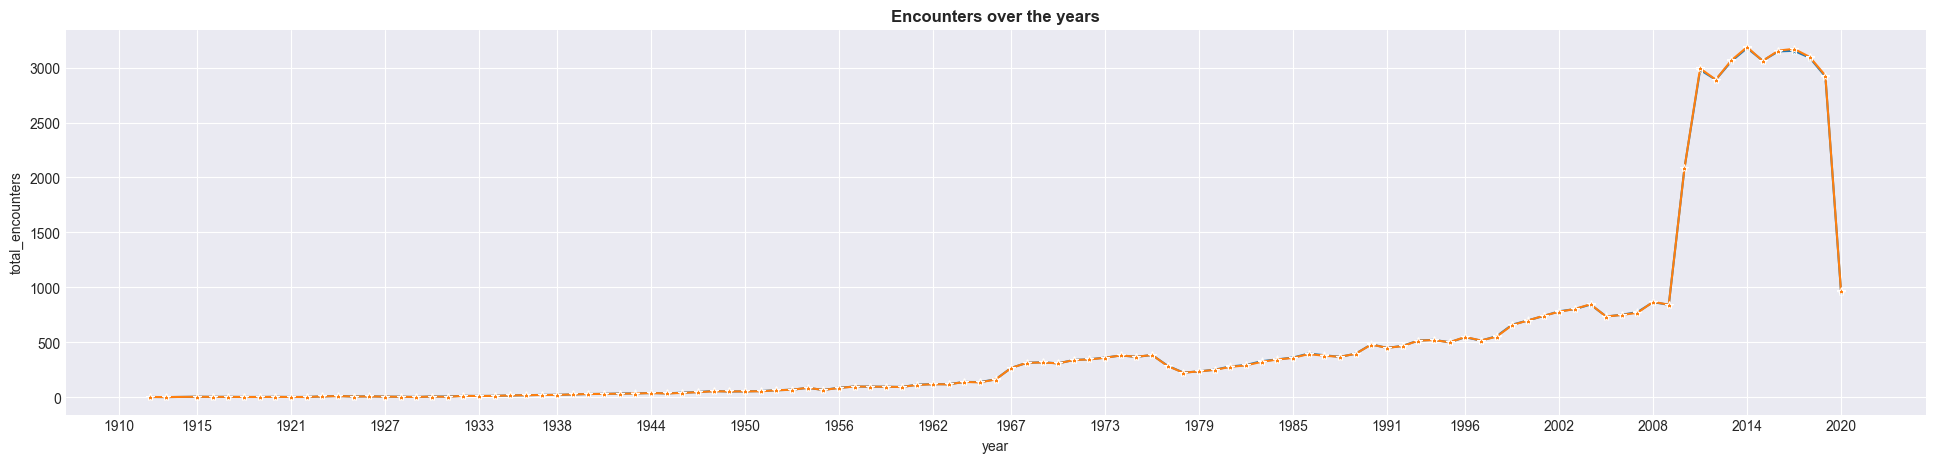

In [117]:
query1 = f'''
    select year(start) as `year`,count(*) as total_encounters from encounters
    group by year(start)
    order by year(start)
'''
encounters_start_per_year = (sql(query1))
query2 = f'''
    select year(stop) as `year`,count(*) as total_encounters from encounters
    group by year(stop)
    order by year(stop)
'''
encounters_stop_per_year = (sql(query2))
plt.figure(figsize=(24,5))
sns.lineplot(x = 'year',y = 'total_encounters',data= encounters_start_per_year,marker='*')
sns.lineplot(x = 'year',y = 'total_encounters',data= encounters_stop_per_year,marker='*')
plt.title('Encounters over the years',weight= 'bold')
plt.grid(alpha = 1)
plt.xticks(np.linspace(1910,2020,20).astype('int'))
plt.show()

`THERE IS SUDDEN PEAK IN ENCOUNTERS AFTER 2008`

`ALSO THERE WAS A SMALL PEAK AFTER YEAR 1965 AND BEFORE 1979`

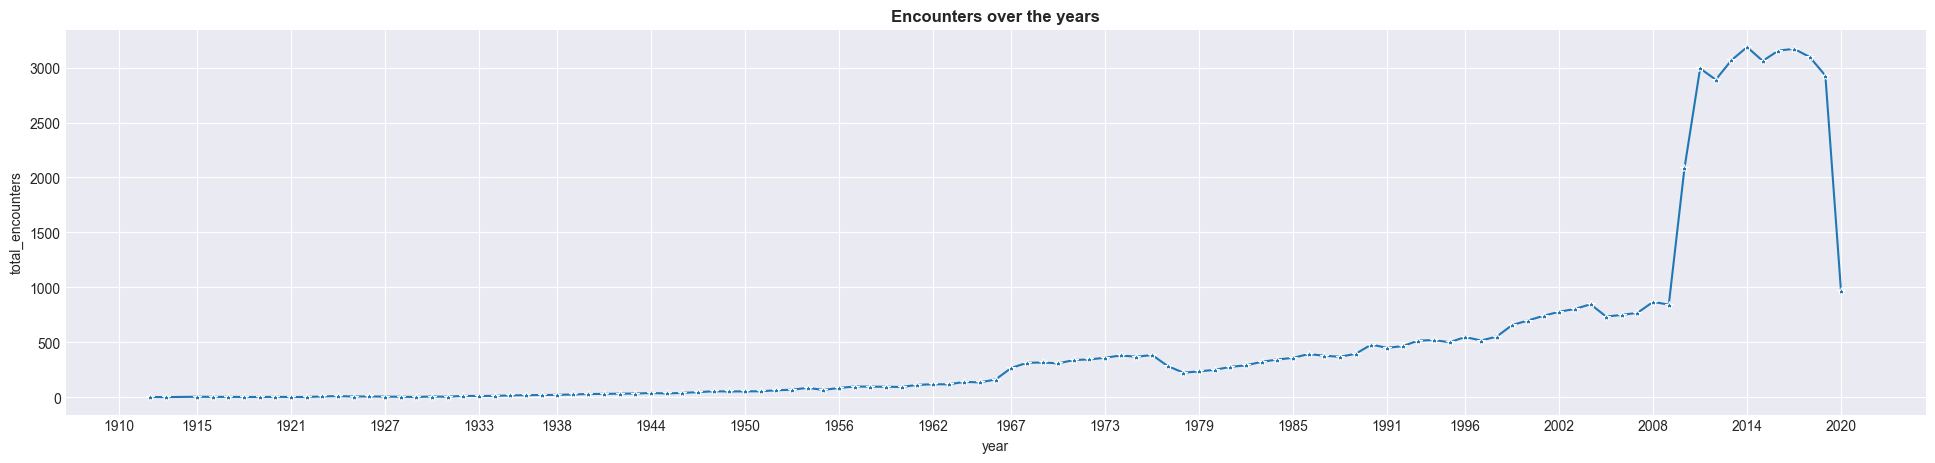

In [115]:
query = f'''
    select year(stop) as `year`,count(*) as total_encounters from encounters
    group by year(stop)
    order by year(stop)
'''
encounters_per_year = (sql(query))
plt.figure(figsize=(24,5))
sns.lineplot(x = 'year',y = 'total_encounters',data= encounters_per_year,marker='*')
plt.title('Encounters over the years',weight= 'bold')
plt.grid(alpha = 1)
plt.xticks(np.linspace(1910,2020,20).astype('int'))
plt.show()

In [103]:
query = '''
    select timestampdiff(MINUTE,start,stop) as duration from encounters;
'''
durations = sql(query)

In [104]:
durations['duration'].describe()

count    5.334600e+04
mean     3.148932e+04
std      8.356058e+05
min      1.500000e+01
25%      1.500000e+01
50%      2.700000e+01
75%      4.500000e+01
max      4.596482e+07
Name: duration, dtype: float64

In [114]:
print(f'99 percentile of duration is limited to: {durations['duration'].quantile(.99)/60} hours')

99 percentile of duration is limited to: 27.0 hours
